# STAT 4710 Final Project -
## *Andrew Raine, Graham Branscom, Mahika Calyanakoti*

## Part 1: Imports and Loading the Dataset

In [ ]:
# Imports
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats

!pip install plotly
import plotly.graph_objects as go

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the kaggle directory and data folder as a directory for the dataset
!mkdir -p ~/.kaggle
!mkdir -p /content/data

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d sidhus/crab-age-prediction

crab-age-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip folder in Colab content folder
!unzip -q -o /content/crab-age-prediction.zip -d /content/data

In [ ]:
df = pd.read_csv('/content/data/CrabAgePrediction.csv')
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6
...,...,...,...,...,...,...,...,...,...
3888,F,1.4625,1.1375,0.3250,24.819987,11.651644,5.854172,6.378637,8
3889,F,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10
3890,I,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5
3891,I,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6


## Part 2: EDA

In [ ]:
#@title Data cleaning and feature engineering
# Checking for nans; none exist
na_counts = df.isna().sum()

# filtering out crab outliers
df = df[df.Height < 1]

# binarizing the age
median_age = df['Age'].median()
df['Young|Old'] = (df['Age'] > median_age).astype(int)

In [ ]:
df.to_csv('cleaned_data.csv', index=False)

In [ ]:
#@title Crab summary
summary_stats = df.describe()
summary_stats

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Young|Old
count,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000,3891.000000
mean,1.311234,1.020827,0.348497,23.558959,10.202101,5.134797,6.794634,9.955281,0.350039
std,0.300408,0.248208,0.096037,13.880211,6.267671,3.101686,3.942167,3.221642,0.477043
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000
25%,1.125000,0.875000,0.287500,12.672227,5.336793,2.664853,3.713785,8.000000,0.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000,0.000000
75%,1.537500,1.200000,0.412500,32.786197,14.266886,7.200773,9.355335,11.000000,1.000000
max,2.037500,1.625000,0.625000,80.101512,42.184056,21.545620,28.491248,29.000000,1.000000


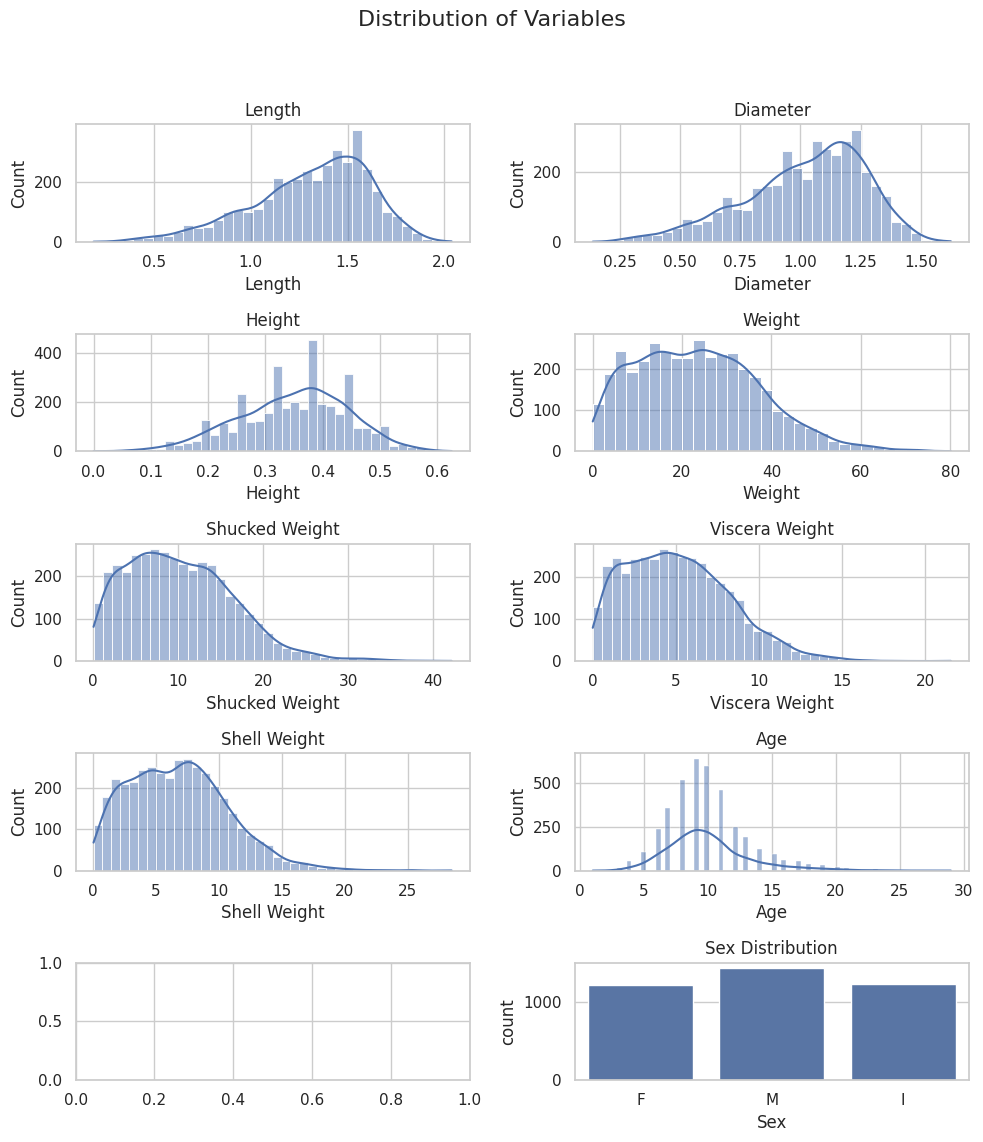

In [ ]:
#@title Variable distributions

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating a figure to hold subplots for histograms
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))

fig.suptitle('Distribution of Variables', fontsize=16)

# Plotting histograms for each numerical variable
num_vars = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']
for ax, var in zip(axes.flat[:-1], num_vars):
    sns.histplot(df[var], kde=True, ax=ax)
    ax.set_title(var)

# Plotting a bar chart for the categorical variable 'Sex'
sns.countplot(x='Sex', data=df, ax=axes.flat[-1])
axes.flat[-1].set_title('Sex Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the subplots to provide space for the main title
plt.show()

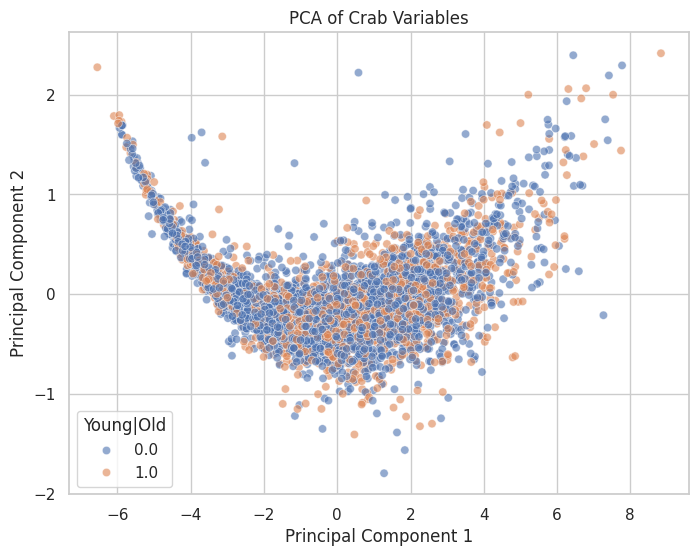



PCA Loadings
	Length: 0.3806276567338248
	Diameter: 0.3810108853408206
	Height: 0.36710538729474895
	Weight: 0.3874789211979131
	Shucked Weight: 0.37480648508033465
	Viscera Weight: 0.3782665434524006
	Shell Weight: 0.3761403106207747


	Length: -0.3043014272247193
	Diameter: -0.3390792470684685
	Height: -0.5624537187565186
	Weight: 0.3132958052943968
	Shucked Weight: 0.4984521051456185
	Viscera Weight: 0.3592745479043055
	Shell Weight: 0.019615206918008693




In [ ]:
#@title PCA
from sklearn.decomposition import PCA

# Independent variables for PCA (excluding 'Age' and 'Young|Old')
pca_vars = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
X_pca = df[pca_vars]

# Standardizing the data for PCA
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# Applying PCA to reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_pca_scaled)

# Creating a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# Including the 'Young|Old' variable for color coding
pca_df['Young|Old'] = df['Young|Old']

# Plotting the 2D scatter plot of the two principal components with color coding
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Young|Old', data=pca_df, alpha=0.6)
plt.title('PCA of Crab Variables')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


print("\n\nPCA Loadings")
for pc_idx in range(2):
  for var, loading in list(zip(pca_vars, pca.components_[pc_idx])):
    print('\t' + var + ":", loading)
  print('\n')

In [ ]:
#@title 3D PCA of Crab Variables Colored By Young|Old
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(X_pca_scaled)

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=df['Young|Old'],                # set color to an array/list of desired values
        colorscale='Viridis',        # choose a colorscale
        opacity=0.8
    )
)])

# Update the layout to add titles and axis labels
fig.update_layout(
    title='3D PCA of Crab Variables',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(r=10, l=10, b=10, t=30)
)

# Show the plot
fig.show()

In [ ]:
#@title 3D PCA of Crab Variables Colored By Age
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(X_pca_scaled)

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=df['Age'],                # set color to an array/list of desired values
        colorscale='Viridis',        # choose a colorscale
        opacity=0.8
    )
)])

# Update the layout to add titles and axis labels
fig.update_layout(
    title='3D PCA of Crab Variables',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(r=10, l=10, b=10, t=30)
)

# Show the plot
fig.show()

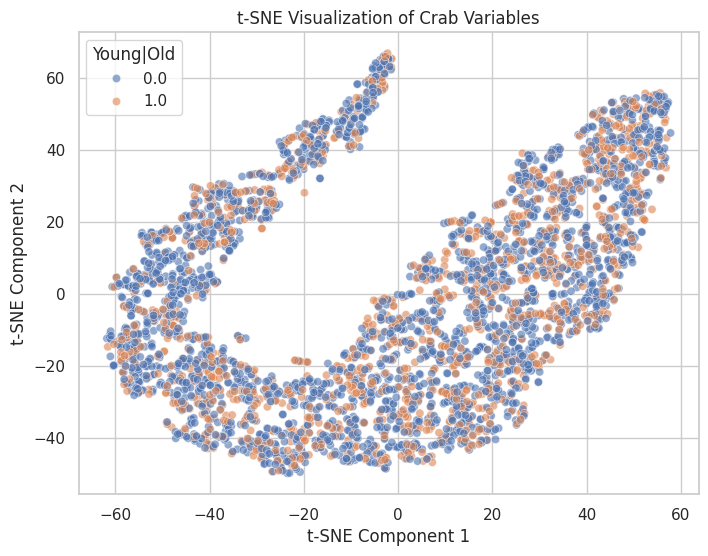

In [ ]:
#@title t-SNE plot
from sklearn.manifold import TSNE

# Setting up t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)

# Applying t-SNE to the scaled data
tsne_results = tsne.fit_transform(X_pca_scaled)

# Creating a DataFrame for the t-SNE components
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Young|Old'] = df['Young|Old']


# Plotting the 2D scatter plot of the two t-SNE components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Young|Old', data=tsne_df, alpha=0.6)
plt.title('t-SNE Visualization of Crab Variables')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

In [ ]:
#@title 3D t-SNE plot

from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pandas as pd

# Assuming 'df' is your DataFrame and 'X_pca_scaled' is your scaled feature set.

# Setting up t-SNE with 3 components for a 3D visualization
tsne_3d = TSNE(n_components=3, random_state=42)

# Applying t-SNE to the scaled data
tsne_results_3d = tsne_3d.fit_transform(X_pca_scaled)

# Creating a DataFrame for the t-SNE components
tsne_df_3d = pd.DataFrame(data=tsne_results_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df_3d['Young|Old'] = df['Young|Old']

# Create an interactive 3D scatter plot using plotly
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_df_3d['TSNE1'],
    y=tsne_df_3d['TSNE2'],
    z=tsne_df_3d['TSNE3'],
    mode='markers',
    marker=dict(
        size=5,
        color=tsne_df_3d['Young|Old'],  # Color by 'Young|Old' binary class
        colorscale='Viridis',           # Choose a colorscale
        opacity=0.8
    )
)])

# Update the layout to add titles and axis labels
fig.update_layout(
    title='3D t-SNE Visualization of Crab Variables',
    scene=dict(
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        zaxis_title='t-SNE Component 3'
    ),
    margin=dict(r=10, l=10, b=10, t=30)
)

# Show the plot
fig.show()


## Part 3: Linear Models

Model Intercept: 2.6872642962138578 

Variable Coefficients
	Length: -1.6239928500390384
	Diameter: 5.344654824660214
	Height: 10.609066661255659
	Weight: 0.3096389204052885
	Shucked Weight: -0.675369328491036
	Viscera Weight: -0.36369893334844394
	Shell Weight: 0.24904915590212529


                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     519.3
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:29:57   Log-Likelihood:                -6827.9
No. Observations:                3112   AIC:                         1.367e+04
Df Residuals:                    3104   BIC:                         1.372e+04
Df Model:                           7                                         
Cova

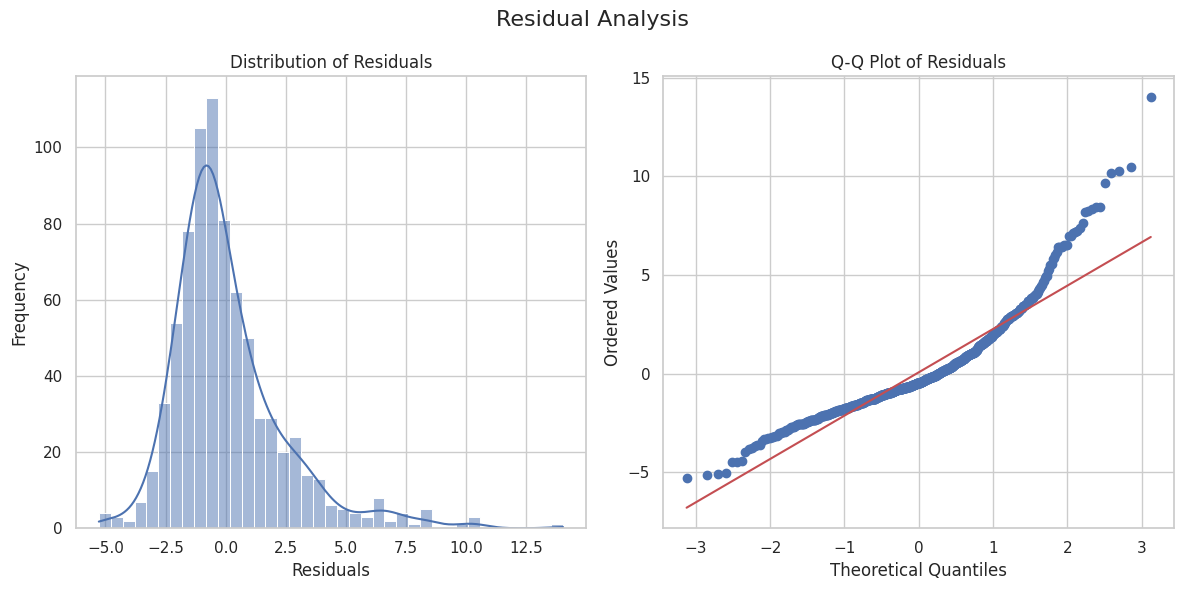

In [ ]:
#@title Vanilla regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot
import statsmodels.api as sm

# Independent variables
ind_variables = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
X = df[ind_variables]
# Dependent variable
y = df['Age']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate R^2 and Mean Squared Error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Adding a constant column to the independent variables matrix for the intercept
X_train_with_const = sm.add_constant(X_train)

# Create and fit the model using statsmodels
model_sm = sm.OLS(y_train, X_train_with_const)
result = model_sm.fit()


print("Model Intercept:", model.intercept_, '\n')


print("Variable Coefficients")
for v_name, v_coef in list(zip(ind_variables, model.coef_)):
  print("\t" + v_name + ": " + str(v_coef))
print('\n')

# Print the summary
print(result.summary())

print("Model R2:", r2, "\n")

print("Model MSE:", mse, "\n")

# Calculating residuals
residuals = y_test - y_pred

# Creating a figure to hold subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Residual Analysis', fontsize=16)

# Plotting the histogram of residuals
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Creating Q-Q plot
probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     214.0
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:29:58   Log-Likelihood:                -6775.6
No. Observations:                3112   AIC:                         1.359e+04
Df Residuals:                    3093   BIC:                         1.370e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7252      1.969      0.

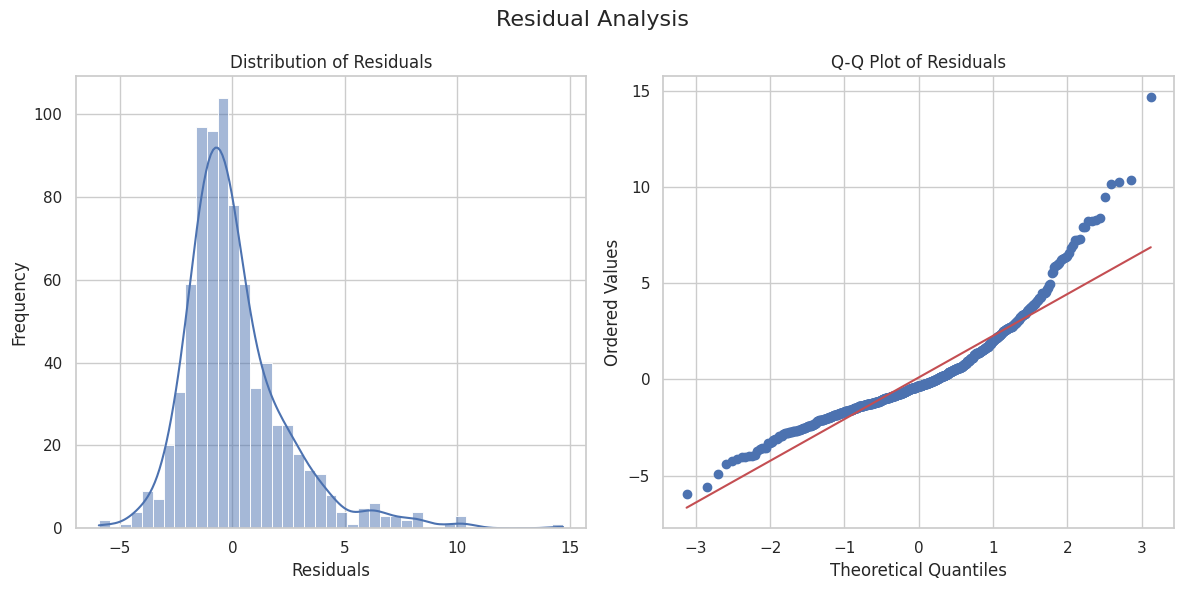

In [ ]:
#@title Vanilla regression with interaction effects
# Interaction effects
X_int = X.copy(deep=True)
X_int["LDHWinteration"] = X.Length * X.Diameter * X.Height * X.Weight
X_int["LDHinteration"] = X.Length * X.Diameter * X.Height
X_int["LDWinteration"] = X.Length * X.Diameter * X.Weight
X_int["LHWinteration"] = X.Length * X.Height * X.Weight
X_int["DHWinteration"] = X.Diameter * X.Height * X.Weight
X_int["LDinteration"] = X.Length * X.Diameter
X_int["LHinteration"] = X.Length * X.Height
X_int["LWinteration"] = X.Length * X.Weight
X_int["DHinteration"] = X.Diameter * X.Height
X_int["DWinteration"] = X.Diameter * X.Weight
X_int["HWinteration"] = X.Height * X.Weight
ind_variables = X_int.columns.tolist()
# Dependent variable
y = df['Age']

# Splitting data into training and testing sets
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(X_int, y, test_size=0.2, random_state=42)

# Adding a constant column to the independent variables matrix for the intercept
X_train_int_with_const = sm.add_constant(X_train_int)

# Create and fit the model using statsmodels
model_sm_int = sm.OLS(y_train_int, X_train_int_with_const)
result_int = model_sm_int.fit()

# Print the summary
print(result_int.summary())

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_int, y_train_int)

# Predict on the testing set
y_pred = model.predict(X_test_int)

# Calculate R^2 and Mean Squared Error
r2 = r2_score(y_test_int, y_pred)
mse = mean_squared_error(y_test_int, y_pred)


print("Model Intercept:", model.intercept_, '\n')


print("Variable Coefficients")
for v_name, v_coef in list(zip(ind_variables, model.coef_)):
  print("\t" + v_name + ": " + str(v_coef))
print('\n')

print("Model R2:", r2, "\n")

print("Model MSE:", mse, "\n")


# Calculating residuals
residuals = y_test_int - y_pred

# Creating a figure to hold subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Residual Analysis', fontsize=16)

# Plotting the histogram of residuals
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Creating Q-Q plot
probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()


In [ ]:
#@title Regularized regression model comparison
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV


def testModel(model_type, X_train_scaled, X_test_scaled):
  if model_type == "Lasso":
    model = Lasso
  elif model_type == "Ridge":
    model = Ridge
  elif model_type == "ElasticNet":
    model = ElasticNet
  else:
    return "provide a correct model type"


  # Defining the range of alpha values to explore
  alpha_range = np.logspace(-4, 2, 50)  # 50 values from 10^-4 to 10^2

  # Setting up the GridSearchCV object
  lasso_grid = GridSearchCV(
      estimator=model(random_state=42, max_iter=10000),
      param_grid={'alpha': alpha_range},
      cv=5,  # 5-fold cross-validation
      scoring='neg_mean_squared_error'
  )

  # Fitting GridSearchCV to the scaled training data
  lasso_grid.fit(X_train_scaled, y_train)

  # Best alpha value and corresponding model
  best_alpha = lasso_grid.best_params_['alpha']
  best_lasso_model = lasso_grid.best_estimator_

  # Evaluating the best model on the test set
  y_pred_best_lasso = best_lasso_model.predict(X_test_scaled)
  best_r2 = r2_score(y_test, y_pred_best_lasso)
  best_mse = mean_squared_error(y_test, y_pred_best_lasso)

  return best_alpha, best_lasso_model.coef_, best_lasso_model.intercept_, best_r2, best_mse




# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


for model in ["Ridge", "Lasso", "ElasticNet"]:
  alpha, coef, interc, r2, mse = testModel(model, X_train_scaled, X_test_scaled)
  print(model)
  for var_name, coef_val in zip(ind_variables, coef):
    print(f"Variable '{var_name}': Coefficient={coef_val}")
  print('\t' + "R2:", r2)
  print('\t' + "MSE:", mse, '\n')

Ridge
Variable 'Length': Coefficient=-0.4778279272437723
Variable 'Diameter': Coefficient=1.3085675235027379
Variable 'Height': Coefficient=1.0146214095856656
Variable 'Weight': Coefficient=4.222196870643839
Variable 'Shucked Weight': Coefficient=-4.19968659760125
Variable 'Viscera Weight': Coefficient=-1.1054048866498596
Variable 'Shell Weight': Coefficient=1.0121084680224237
	R2: 0.5072323023139451
	MSE: 5.396094597754641 

Lasso
Variable 'Length': Coefficient=-0.47426998946852084
Variable 'Diameter': Coefficient=1.3060745693980242
Variable 'Height': Coefficient=1.0137959766997786
Variable 'Weight': Coefficient=4.275570412638464
Variable 'Shucked Weight': Coefficient=-4.224886312568092
Variable 'Viscera Weight': Coefficient=-1.1168867513454228
Variable 'Shell Weight': Coefficient=0.9934463221119904
	R2: 0.5073487022179243
	MSE: 5.3948199507029155 

ElasticNet
Variable 'Length': Coefficient=-0.4698816389990608
Variable 'Diameter': Coefficient=1.3007276948733622
Variable 'Height': Coef

The vanilla regression model and vanilla regression with interaction effects outperform all of the regularized ones.

In [ ]:
#@title Logistic regression on age (young or old)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Independent variables (excluding 'Age' and including only relevant predictors)
X_logistic = df[['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']]
# Dependent binary variable
y_logistic = df['Young|Old']

# Standardizing the data
scaler_logistic = StandardScaler()
X_logistic_scaled = scaler_logistic.fit_transform(X_logistic)

# Splitting data into training and testing sets for logistic regression
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_logistic_scaled, y_logistic, test_size=0.2, random_state=42)

# Setting up the logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Fitting the logistic regression model
logistic_model.fit(X_train_log, y_train_log)

# Predicting using the logistic regression model
y_pred_logistic = logistic_model.predict(X_test_log)
y_pred_proba_logistic = logistic_model.predict_proba(X_test_log)[:, 1]  # probabilities for ROC-AUC

# Evaluating the model
accuracy = accuracy_score(y_test_log, y_pred_logistic)
precision = precision_score(y_test_log, y_pred_logistic)
recall = recall_score(y_test_log, y_pred_logistic)
roc_auc = roc_auc_score(y_test_log, y_pred_proba_logistic)

accuracy, precision, recall, roc_auc

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

Accuracy: 0.7753530166880617
Precision: 0.7635467980295566
Recall: 0.549645390070922
ROC AUC: 0.8366653823651127


## Part 4: Tree Models

R2: 0.5220396296821315
MSE: 5.233945699614891 




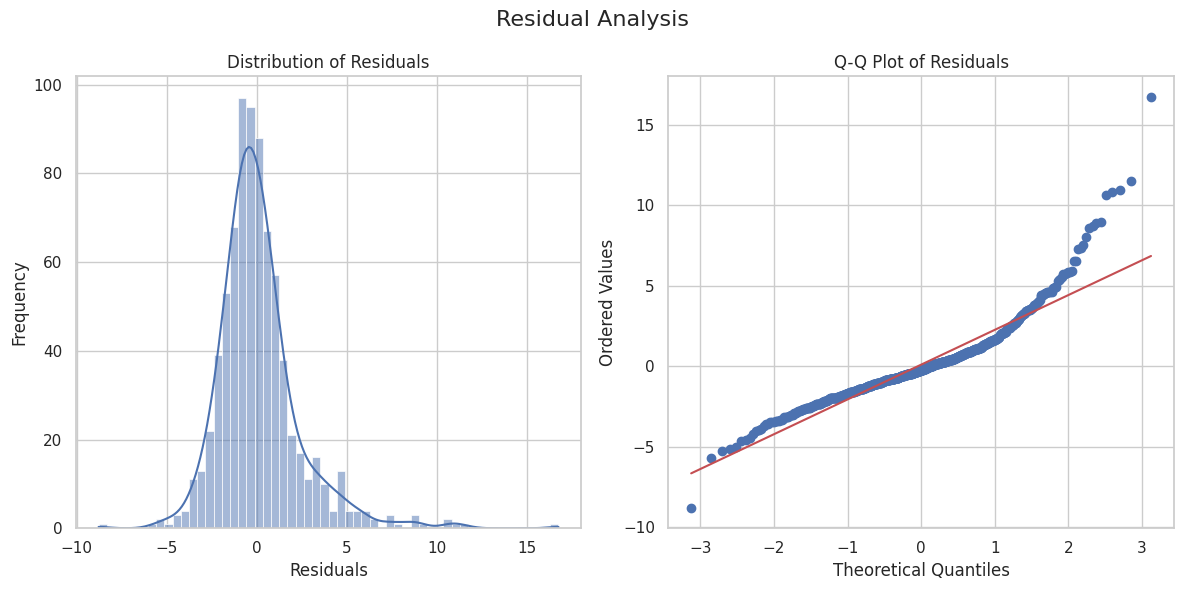

In [ ]:
#@title Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot
from sklearn.metrics import r2_score

# Selecting predictor variables (excluding 'Young|Old')
predictor_vars = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
X_rf = df[predictor_vars]
y_rf = df['Age']

# Splitting the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Creating a random forest regressor model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
random_forest_model.fit(X_train_rf, y_train_rf)

# Predicting on the test data
y_pred_rf = random_forest_model.predict(X_test_rf)

# Calculating residuals
residuals_rf = y_test_rf - y_pred_rf

# R^2 score
r2_rf = r2_score(y_test_rf, y_pred_rf)
print("R2:", r2_rf)

# Mean Squared Error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
print("MSE:", mse_rf, "\n\n")


# Creating a figure to hold subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Residual Analysis', fontsize=16)

# Plotting the histogram of residuals
sns.histplot(residuals_rf, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Creating Q-Q plot
probplot(residuals_rf, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()

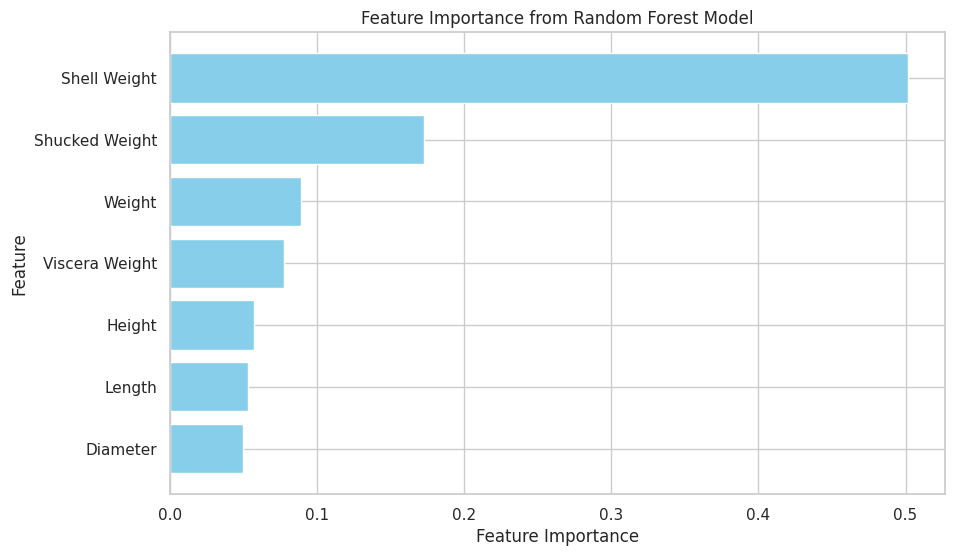

In [ ]:
# Assuming best_rf_model is your trained RandomForestClassifier or RandomForestRegressor
feature_importances = random_forest_model.feature_importances_
feature_importances_sorted = sorted(zip(predictor_vars, feature_importances), key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
# plt.barh(predictor_vars, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.show()

In [ ]:
#@title XGBoost Regressor
import xgboost as xgb

# XGBoost Regression
# Prepare the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Create the XGBoost regressor model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Fit the model
xgb_regressor.fit(X_train_reg, y_train_reg)

# Predict on the test data
y_pred_reg = xgb_regressor.predict(X_test_reg)

# Evaluate the model
r2_xgb_reg = r2_score(y_test_reg, y_pred_reg)
mse_xgb_reg = mean_squared_error(y_test_reg, y_pred_reg)

r2_xgb_reg, mse_xgb_reg

# R^2 score
print("R2:", r2_xgb_reg)

# Mean Squared Error
print("MSE:", mse_xgb_reg, "\n\n")

R2: 0.4689048606432701
MSE: 5.815802508634486 




The random forest regressor is the best model yet, even beating the XGBoost regressor.

In [ ]:
#@title Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Assuming 'Young|Old' is binary and properly encoded, i.e., 0 for 'Young' and 1 for 'Old'
# Prepare the data
y_classifier = df['Young|Old']

# Split the data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_rf, y_classifier, test_size=0.2, random_state=42)

# Create a Random Forest Classifier model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
random_forest_classifier.fit(X_train_class, y_train_class)

# Predict on the test data
y_pred_class = random_forest_classifier.predict(X_test_class)
y_pred_proba_class = random_forest_classifier.predict_proba(X_test_class)[:, 1]  # probabilities for the positive class

# Evaluate the model
accuracy_class = accuracy_score(y_test_class, y_pred_class)
precision_class = precision_score(y_test_class, y_pred_class)
recall_class = recall_score(y_test_class, y_pred_class)
roc_auc_class = roc_auc_score(y_test_class, y_pred_proba_class)

# Residual-like analysis: Difference between actual and predicted probabilities
residuals_class = y_test_class - y_pred_proba_class

print("Accuracy:", accuracy_class)
print("Precision:", precision_class)
print("Recall:", recall_class)
print("ROC AUC:", roc_auc_class)

Accuracy: 0.7753530166880617
Precision: 0.73568281938326
Recall: 0.5921985815602837
ROC AUC: 0.8449277223625441


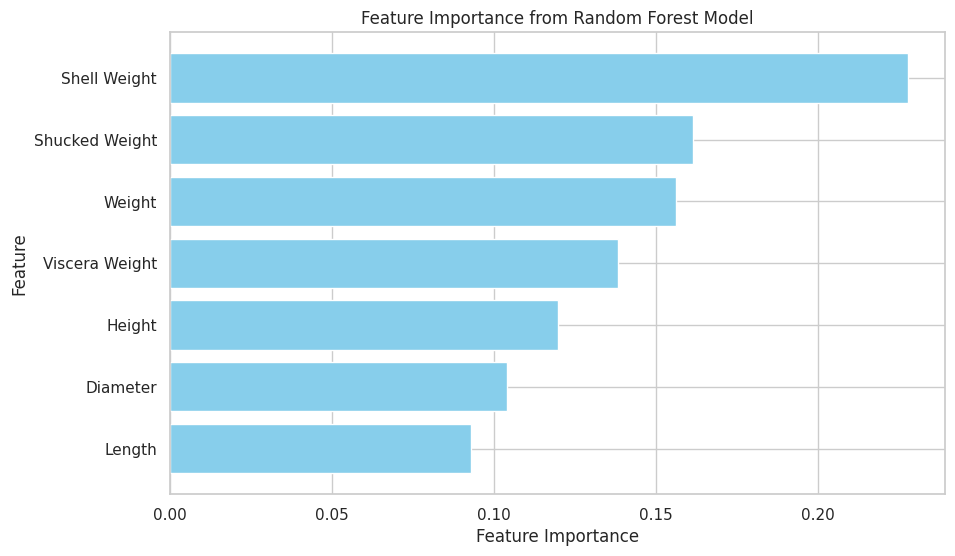

In [ ]:
# Assuming best_rf_model is your trained RandomForestClassifier or RandomForestRegressor
feature_importances = random_forest_classifier.feature_importances_
feature_importances_sorted = sorted(zip(predictor_vars, feature_importances), key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
# plt.barh(predictor_vars, feature_importances_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.show()

In [ ]:
#@title XGBoost Classification
# Prepare the data for classification
y_class = df['Young|Old']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_rf, y_class, test_size=0.2, random_state=42)

# Create the XGBoost classifier model
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_classifier.fit(X_train_class, y_train_class)

# Predict on the test data
y_pred_class = xgb_classifier.predict(X_test_class)
y_pred_proba_class = xgb_classifier.predict_proba(X_test_class)[:, 1]  # probabilities for the positive class

# Evaluate the model
accuracy_class = accuracy_score(y_test_class, y_pred_class)
precision_class = precision_score(y_test_class, y_pred_class)
recall_class = recall_score(y_test_class, y_pred_class)
roc_auc_class = roc_auc_score(y_test_class, y_pred_proba_class)

print("Accuracy:", accuracy_class)
print("Precision:", precision_class)
print("Recall:", recall_class)
print("ROC AUC:", roc_auc_class)

Accuracy: 0.7573812580231065
Precision: 0.6882591093117408
Recall: 0.6028368794326241
ROC AUC: 0.834375044593804


## Part 5: Artificial Neural Network

In [ ]:
#@title Data preparation
# converting the sex to a numeric
df['Sex'] = df['Sex'].apply(lambda x: {'F': 0, 'M': 1, 'I': 2}[x])

<ipython-input-126-57f296e4ce7b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title DataLoaders
import torch
from torch.utils.data import TensorDataset, DataLoader


def dataloadersFor(dependent_var, batch_size=32):
  cols = df.columns.tolist()
  cols.remove("Age")
  cols.remove("Young|Old")

  assert dependent_var in {"Age", "Young|Old"}


  features = torch.tensor(df[cols].values).float()  # Assuming all features are numeric
  targets = torch.tensor(df[dependent_var].values).float()

  features_np = features.numpy()
  targets_np = targets.numpy()

  # Split data into training and testing sets (80% train, 20% test)
  X_train, X_test, y_train, y_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

  # Convert numpy arrays back to tensors
  X_train = torch.tensor(X_train).float()
  y_train = torch.tensor(y_train).float()
  X_test = torch.tensor(X_test).float()
  y_test = torch.tensor(y_test).float()

  # Create TensorDatasets for train and test sets
  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  # Create DataLoaders for train and test sets
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader



In [ ]:
#@title Model
import torch.nn as nn

class FFN(nn.Module):
  def __init__(self, task):
    super(FFN, self).__init__()

    assert task in {"regression", "classification"}

    self.task = task

    self.backbone = nn.ModuleList([nn.BatchNorm1d(8, affine=False)])
    for i in range(5):
      self.backbone.append(nn.Linear(8, 8))
      self.backbone.append(nn.Tanh())
      # self.backbone.append(nn.Dropout(0.2))
    self.backbone.append(nn.Linear(8, 4))

    if task == "regression":
      self.head = nn.Linear(4, 1)
    else:
      self.head = nn.Linear(4, 2)


  def forward(self, x, raw=False):
    for layer in self.backbone:
      x = layer(x)
    x_logits = x
    x = self.head(x_logits)

    if self.task == "classification":
      x = nn.Softmax(dim=1)(x)

    if raw:
      return x, x_logits
    return x

In [ ]:
#@title Loss function and optimizer
def lossFn(task):
  assert task in {"regression", "classification"}
  if task == "regression":
    return nn.MSELoss()
  return nn.CrossEntropyLoss()

def initOptim(model):
  return torch.optim.Adam(model.parameters())

In [ ]:
#@title Train and test functions

def train(model, train_loader, loss_fn, optimizer, device, print_every=50):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to the appropriate device
        data, targets = data.to(device), targets.to(device)
        if model.task == "classification":
            targets = targets.long()

        # Forward pass
        outputs = model(data)
        if model.task == "regression":
            outputs = outputs.squeeze(-1)
        loss = loss_fn(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # For classification, calculate the number of correct predictions
        if model.task == "classification":
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Print training update and optionally invoke testing function periodically
        if (batch_idx + 1) % print_every == 0:
            avg_loss = total_loss / print_every
            if model.task == "classification":
                accuracy = 100 * correct / total
                print(f"Batch {batch_idx + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
            else:
                print(f"Batch {batch_idx + 1}: Loss = {avg_loss:.4f}")
            total_loss = 0  # Reset the loss for the next set of batches
            correct = 0  # Reset the correct count
            total = 0  # Reset the total count


def test(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data to the appropriate device
            data, targets = data.to(device), targets.to(device)
            if model.task == "classification":
              targets = targets.long()

            # Forward pass
            outputs = model(data)
            if model.task == "regression":
                outputs = outputs.squeeze(-1)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # For classification, calculate the number of correct predictions
            if model.task == "classification":
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

    # Print test results
    if model.task == "classification":
        print(f"Test Loss: {total_loss / len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    else:
        print(f"Test Loss: {total_loss / len(test_loader):.4f}")



def trainAndTest(task, epochs=30):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  model = FFN(task).to(device)
  loss_fn = lossFn(task)
  optim = initOptim(model)

  train_loader, test_loader = dataloadersFor("Age" if task == "regression" else "Young|Old")

  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}")
      train(model, train_loader, loss_fn, optim, device, print_every=10)
      test(model, test_loader, loss_fn, device)
      print('\n')
  return model, test_loader

In [ ]:
#@title Classification
class_model, class_test_data = trainAndTest("classification")

Epoch 1
Batch 10: Loss = 0.6867, Accuracy = 65.00%
Batch 20: Loss = 0.6746, Accuracy = 69.69%
Batch 30: Loss = 0.6700, Accuracy = 66.25%
Batch 40: Loss = 0.6583, Accuracy = 66.56%
Batch 50: Loss = 0.6425, Accuracy = 69.06%
Batch 60: Loss = 0.6570, Accuracy = 58.12%
Batch 70: Loss = 0.6247, Accuracy = 66.88%
Batch 80: Loss = 0.6158, Accuracy = 72.50%
Batch 90: Loss = 0.6129, Accuracy = 69.69%
Test Loss: 0.5949, Accuracy: 73.04%


Epoch 2
Batch 10: Loss = 0.5915, Accuracy = 69.69%
Batch 20: Loss = 0.6128, Accuracy = 67.19%
Batch 30: Loss = 0.5931, Accuracy = 70.31%
Batch 40: Loss = 0.5794, Accuracy = 72.81%
Batch 50: Loss = 0.5591, Accuracy = 74.69%
Batch 60: Loss = 0.5724, Accuracy = 70.94%
Batch 70: Loss = 0.5543, Accuracy = 73.44%
Batch 80: Loss = 0.5917, Accuracy = 70.31%
Batch 90: Loss = 0.5777, Accuracy = 70.31%
Test Loss: 0.5659, Accuracy: 74.58%


Epoch 3
Batch 10: Loss = 0.5434, Accuracy = 75.62%
Batch 20: Loss = 0.5478, Accuracy = 75.31%
Batch 30: Loss = 0.5965, Accuracy = 69.6

In [ ]:
#@title Regression
reg_model, reg_test_data = trainAndTest("regression", 50)

Epoch 1
Batch 10: Loss = 91.1427
Batch 20: Loss = 91.2421
Batch 30: Loss = 94.0418
Batch 40: Loss = 90.6227
Batch 50: Loss = 87.9925
Batch 60: Loss = 79.3302
Batch 70: Loss = 82.3218
Batch 80: Loss = 71.0317
Batch 90: Loss = 72.8962
Test Loss: 58.3384


Epoch 2
Batch 10: Loss = 58.8409
Batch 20: Loss = 60.1046
Batch 30: Loss = 42.6817
Batch 40: Loss = 40.2391
Batch 50: Loss = 35.5226
Batch 60: Loss = 29.0844
Batch 70: Loss = 28.8568
Batch 80: Loss = 29.2687
Batch 90: Loss = 24.2316
Test Loss: 21.1164


Epoch 3
Batch 10: Loss = 20.4493
Batch 20: Loss = 15.2075
Batch 30: Loss = 14.2824
Batch 40: Loss = 15.0294
Batch 50: Loss = 14.6226
Batch 60: Loss = 12.1941
Batch 70: Loss = 15.1486
Batch 80: Loss = 12.5043
Batch 90: Loss = 11.0391
Test Loss: 10.0775


Epoch 4
Batch 10: Loss = 10.3545
Batch 20: Loss = 9.0284
Batch 30: Loss = 9.5050
Batch 40: Loss = 9.2756
Batch 50: Loss = 10.5331
Batch 60: Loss = 7.9792
Batch 70: Loss = 7.2549
Batch 80: Loss = 9.2489
Batch 90: Loss = 8.0763
Test Loss: 7

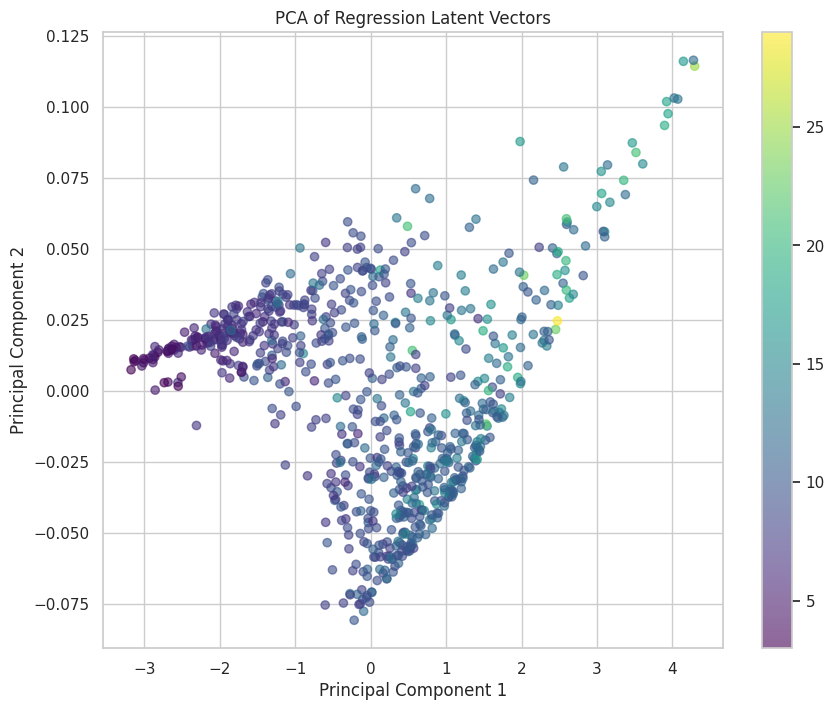

In [ ]:
#@title PCA on the neural network regression latent vectors
embeddings = []
labels = []
for data, label in reg_test_data:
  _, embedding = reg_model(data, raw=True)
  embeddings.append(embedding)
  labels.append(label)
embeddings = torch.cat(embeddings, axis=0)
labels = torch.cat(labels, axis=0)

# Detach the tensor and convert to NumPy for PCA processing
if embeddings.requires_grad:
    embeddings_np = embeddings.detach().cpu().numpy()
else:
    embeddings_np = embeddings.cpu().numpy()

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_np)

# Plotting the embeddings with labels as color codes
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)

plt.colorbar(scatter)  # Show color scale
plt.title('PCA of Regression Latent Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
#@title Interactive 3D projection of regression latent vectors
# Import necessary libraries
import plotly.graph_objects as go

# Detach and convert embeddings to numpy if needed
embeddings_np = embeddings.detach().cpu().numpy() if embeddings.requires_grad else embeddings.cpu().numpy()

# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_np)

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,                # set color to an array/list of desired values
        colorscale='Viridis',        # choose a colorscale
        opacity=0.8
    )
)])

# Update the layout to add titles and axis labels
fig.update_layout(
    title='3D PCA Visualization of Regression Latent Vectors',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(r=10, l=10, b=10, t=30),
    legend=dict(title='Labels')
)

# Show the plot
fig.show()

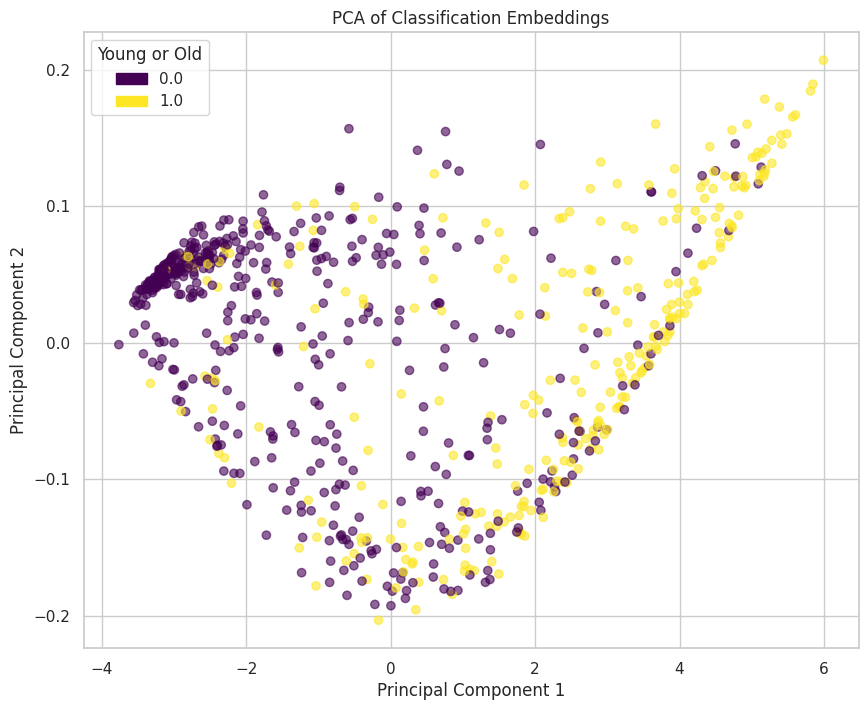

In [ ]:
#@title PCA on the neural network classification latent vectors
embeddings = []
labels = []
for data, label in class_test_data:
  _, embedding = class_model(data, raw=True)
  embeddings.append(embedding)
  labels.append(label)
embeddings = torch.cat(embeddings, axis=0)
labels = torch.cat(labels, axis=0)


# Assume embeddings and labels are already defined
# Detach and convert embeddings to numpy array if they're PyTorch tensors
if embeddings.requires_grad:
    embeddings_np = embeddings.detach().cpu().numpy()
else:
    embeddings_np = embeddings.cpu().numpy()

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_np)

# Plotting the embeddings with labels as color codes
plt.figure(figsize=(10, 8))
# Create a scatter plot and assign it to a variable for the legend
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)

# Create a legend
# Generate unique labels and corresponding colors from the scatter plot
classes = np.unique(labels)
colors = [scatter.cmap(scat) for scat in np.linspace(0, 1, len(classes))]
legend_labels = {class_: color for class_, color in zip(classes, colors)}

# Create custom patches to handle the legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=legend_labels[class_], label=class_) for class_ in classes]
plt.legend(handles=legend_handles, title="Young or Old")

plt.title('PCA of Classification Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
#@title Interactive 3D projection of classification latent vectors
# Import necessary libraries
import plotly.graph_objects as go

# Detach and convert embeddings to numpy if needed
embeddings_np = embeddings.detach().cpu().numpy() if embeddings.requires_grad else embeddings.cpu().numpy()

# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_np)

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    z=reduced_embeddings[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,                # set color to an array/list of desired values
        colorscale='Viridis',        # choose a colorscale
        opacity=0.8
    )
)])

# Update the layout to add titles and axis labels
fig.update_layout(
    title='3D PCA Visualization of Classification Latent Vectors',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    margin=dict(r=10, l=10, b=10, t=30)
)

# Show the plot
fig.show()

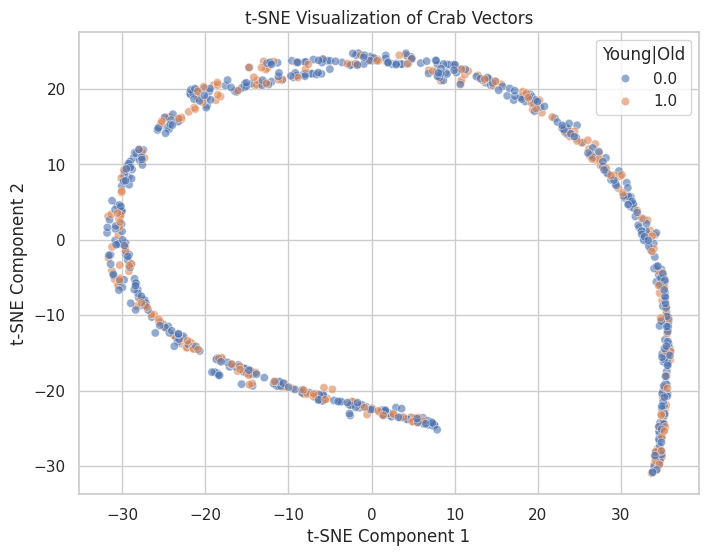

In [ ]:
#@title crab snake
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(embeddings_np)


# Setting up t-SNE with 2 components
# tsne = TSNE(n_components=2, random_state=42)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)

# Applying t-SNE to the scaled data
tsne_results = tsne.fit_transform(X_pca_scaled)

# Creating a DataFrame for the t-SNE components
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Young|Old'] = df['Young|Old']


# Plotting the 2D scatter plot of the two t-SNE components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Young|Old', data=tsne_df, alpha=0.6)
plt.title('t-SNE Visualization of Crab Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()